In [1]:
# import relevant libraries
import numpy as np
import pandas as pd
import sklearn
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import rasterio
from rasterio.plot import show
import cv2
import numpy as np

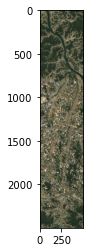

In [3]:
# Reading RGB render of the ROI
# This region is located in Icheon, South Korea
# The RGB values has been downloaded from Sentinel-2 open source satellite images
file_path = 'Sentinel_2_data/icheon_cropped.tif'
dataset = rasterio.open(file_path)
red_band = dataset.read(1)
green_band = dataset.read(2)
blue_band = dataset.read(3)
icheon = cv2.merge([red_band, green_band, blue_band])
plt.imshow(icheon)
dataset.close()

In [4]:
# Reading in all relevant bands from Sentinel-2 data.
dataset = rasterio.open('Sentinel_2_data/B2_cropped.tif')
b2_band = dataset.read(1) # The blue band
dataset.close()

dataset = rasterio.open('Sentinel_2_data/B3_cropped.tif')
b3_band = dataset.read(1) # The green band
dataset.close()

dataset = rasterio.open('Sentinel_2_data/B4_cropped.tif')
b4_band = dataset.read(1) # The red band
dataset.close()

dataset = rasterio.open('Sentinel_2_data/B5_cropped.tif')
b5_band = dataset.read(1) # The Vegetation Red 1 band
dataset.close()

dataset = rasterio.open('Sentinel_2_data/B6_cropped.tif')
b6_band = dataset.read(1) # The Vegetation Red 2 band
dataset.close()

dataset = rasterio.open('Sentinel_2_data/B7_cropped.tif')
b7_band = dataset.read(1) # The Vegetation Red 3 band
dataset.close()

dataset = rasterio.open('Sentinel_2_data/B8A_cropped.tif')
b8a_band = dataset.read(1) # The Vegetation Red 4 band
dataset.close()

dataset = rasterio.open('Sentinel_2_data/B11_cropped.tif')
b11_band = dataset.read(1) # The Shortwave-Infrared 1 band
dataset.close()

dataset = rasterio.open('Sentinel_2_data/B12_cropped.tif')
b12_band = dataset.read(1) # The Shortwave-Infrared 2 band
dataset.close()

# This is a special tif file made using qgis.
# This 1 channel image shows whether a pixel is a bare soil or not.
# It has been calculated based on this formula: BSI(Bare Soil Index)>0.08 AND UCI(Urban Composite Index)<-0.33
# The information on these spectral indices (BSI and UCI) can be found in the references attached at end of this notebook
dataset = rasterio.open('Sentinel_2_data/is_bare_soil_33.tif')
is_bare_soil = dataset.read(1) 
dataset.close()

print(np.unique(is_bare_soil))

[0. 1.]


In [5]:
# Saving band information only on soil pixels
inference_map = is_bare_soil.copy()

bands = {'b2':b2_band, 'b3':b3_band, 'b4':b4_band, 'b5':b5_band, 'b6':b6_band, 'b7':b7_band, 'b8a': b8a_band, 'b11':b11_band, 'b12': b12_band}
row_list = []
col_list = []
band_list_dict = dict()
for i in bands.keys():
    band_list_dict[i] = []

for i in range(len(is_bare_soil)):
    for j in range(len(is_bare_soil[0])):
        if is_bare_soil[i][j] == 1:
            row_list.append(i)
            col_list.append(j)
            for band in band_list_dict.keys():
                band_list_dict[band].append(bands[band][i][j])
            
demo_X = pd.DataFrame()
demo_X['row'] = row_list
demo_X['col'] = col_list
for band in band_list_dict.keys():
    demo_X[band] = band_list_dict[band]

In [7]:
# Feature engineering
demo_X['NDVI'] = (demo_X['b8a'] - demo_X['b4']) / (demo_X['b8a'] + demo_X['b4'])
demo_X['BSI'] = ((demo_X['b11'] + demo_X['b4']) - (demo_X['b8a'] + demo_X['b2'])) / (demo_X['b11'] + demo_X['b4']) + (demo_X['b8a'] + demo_X['b2'])
demo_X['EVI'] = 2.5 * ((demo_X['b8a'] - demo_X['b4']) / (demo_X['b8a'] + 6*demo_X['b4'] - 7.5*demo_X['b2'] + 1))
demo_X['SAVI'] = (demo_X['b8a'] - demo_X['b4']) / (demo_X['b8a'] + demo_X['b4'] + 0.428) * (1.428)
demo_X['NDMI'] = (demo_X['b8a'] - demo_X['b11']) / (demo_X['b8a'] + demo_X['b11'])

demo_X['b2'] = demo_X['b2']/10000
demo_X['b3'] = demo_X['b3']/10000
demo_X['b4'] = demo_X['b4']/10000
demo_X['b5'] = demo_X['b5']/10000
demo_X['b6'] = demo_X['b6']/10000
demo_X['b7'] = demo_X['b7']/10000
demo_X['b8a'] = demo_X['b8a']/10000
demo_X['b11'] = demo_X['b11']/10000
demo_X['b12'] = demo_X['b12']/10000

demo_X.head(2)

,row,col,b2,b3,b4,b5,b6,b7,b8a,b11,b12,NDVI,BSI,EVI,SAVI,NDMI
0,0,34,0.1745,0.1821,0.1840,0.2069,0.2634,0.3348,0.2926,0.4731,0.4737,0.227864,4671.289149,3.086981,0.325361,-0.235732
1,0,125,0.1823,0.2193,0.2587,0.2966,0.3212,0.3254,0.3491,0.4459,0.4139,0.148733,5314.245813,0.423102,0.212376,-0.121761


In [9]:
# Loading the Random Forest Regressor Model
from joblib import load
from sklearn.ensemble import RandomForestRegressor

model_file_path = 'SOC_onlyband_RFR.joblib'
loaded_model = load(model_file_path)

if isinstance(loaded_model, RandomForestRegressor):
    print("Random Forest Regressor model loaded successfully.")
else:
    print("The loaded model is not a Random Forest Regressor.")

Random Forest Regressor model loaded successfully.


c:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


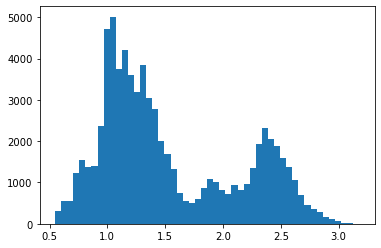

In [10]:
# Inference
predictions = loaded_model.predict(np.array(demo_X.iloc[:,2:]))
demo_X['predictions'] = predictions
plt.hist(demo_X['predictions'],bins=50)
plt.show()

In [11]:
# Replacing blank image with inferred values
for i in demo_X.index:
    row = demo_X.loc[i,'row']
    col = demo_X.loc[i,'col']
    soc = 3.5 - demo_X.loc[i,'predictions']
    inference_map[row][col] = soc

Here the redder parts show almost 0% SOC and cooler parts show around 3% SOC


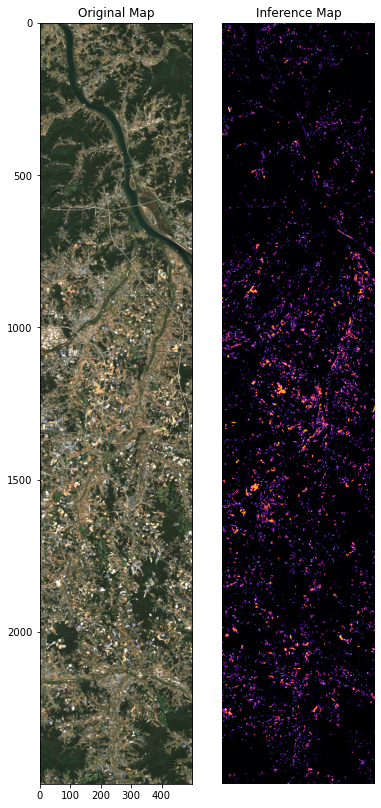

In [13]:
print('Here the redder parts show almost 0% SOC and cooler parts show around 3% SOC')
fig, axs = plt.subplots(1, 2, figsize=(6,16))
axs[0].imshow(icheon, cmap='inferno')
axs[0].set_title('Original Map')
plt.axis('off')
axs[1].imshow(inference_map, cmap='inferno')
axs[1].set_title('Inference Map')
plt.axis('off')
plt.show()

References:
1. https://www.mdpi.com/2072-4292/13/1/3
2. https://www.sciencedirect.com/science/article/pii/S1569843223002947
3. https://www.mdpi.com/2072-4292/13/3/474#:~:text=From%20inspection%20of%20the%20Sentinel,were%20classified%20as%20bare%20soil.